        date  day_of_week  baseline  trend  seasonality  facebook_spend  \
0 2023-01-01            6     100.0    0.0     7.181685     1660.934073   
1 2023-01-02            0     100.0    0.1     0.000000     1158.317660   
2 2023-01-03            1     100.0    0.2     7.818315     1787.896880   
3 2023-01-04            2     100.0    0.3     9.749279     1546.052044   
4 2023-01-05            3     100.0    0.4     4.338837      641.266022   

   search_spend  display_spend      noise  registrations  
0   1331.368913     993.695892  54.079702            298  
1    886.632820     786.429023   7.884753            203  
2    989.720626     464.527893 -14.389631            206  
3   1453.657443     588.660707 -13.885275            227  
4    902.898366     887.872697 -18.853598            168  

=== OLS Coefficients ===
const               42.137919
trend                0.950636
seasonality          0.861376
adstock_facebook     0.012957
adstock_search       0.031042
adstock_display    

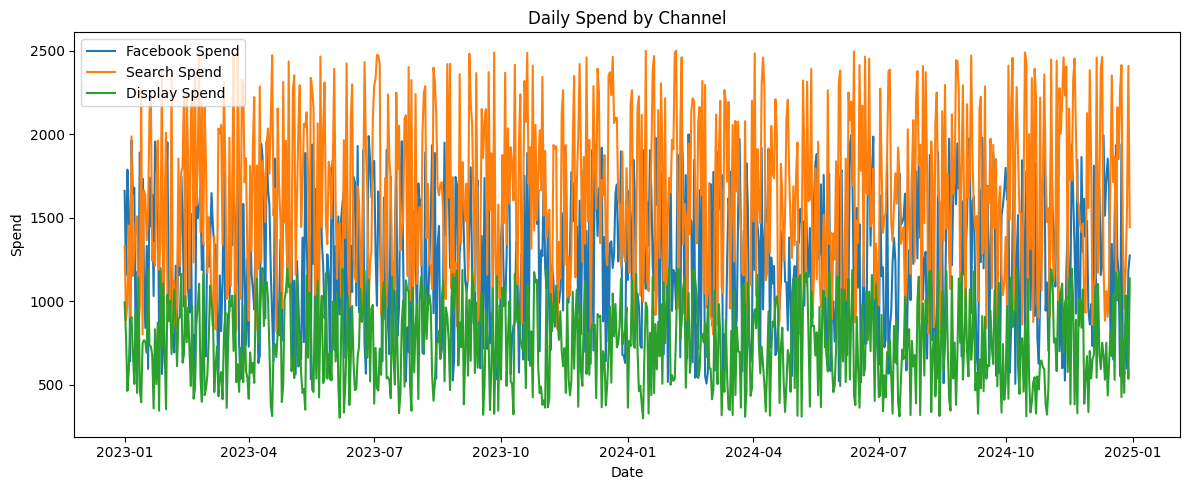

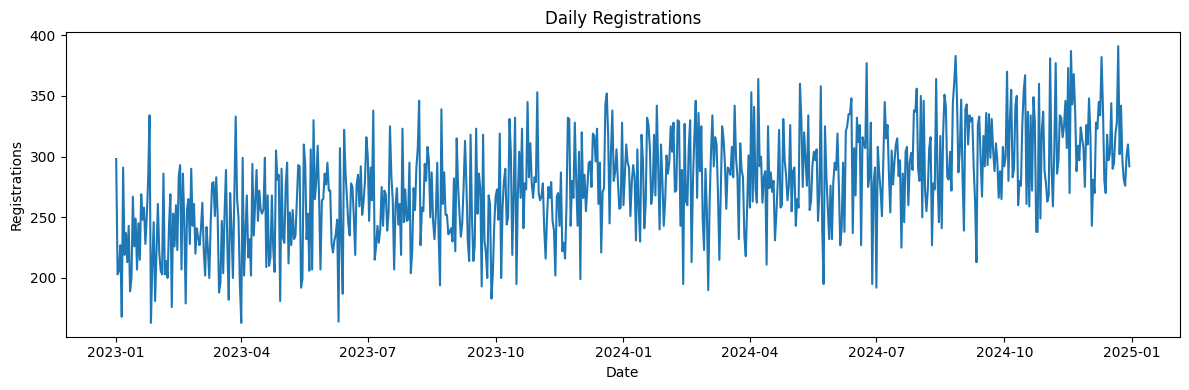

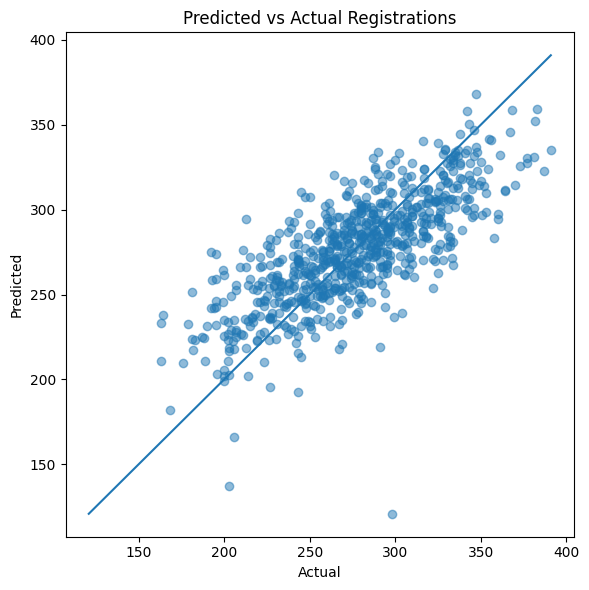

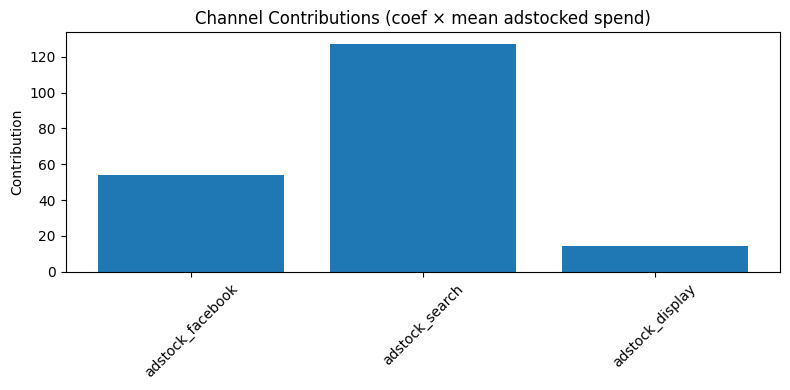

In [9]:
"""
Marketing Mix Modeling (MMM) - Clean End-to-End Template

Sections:
1. Data Simulation
2. Adstock Transformation
3. Regression Modeling (statsmodels OLS)
4. Evaluation & Multicollinearity
5. Visualizations
"""

# ==============================
# Imports
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# ==============================
# 1. Data Simulation
# ==============================

def simulate_daily_mmm_data(
    start_date: str = "2023-01-01",
    n_days: int = 730,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Simulate 2 years of daily marketing mix data.

    Includes:
    - baseline + trend
    - weekly seasonality (day-of-week pattern)
    - 3 channels: Facebook, Search, Display (daily spend)
    - KPI: registrations (with noise)
    """
    rng = np.random.default_rng(random_state)

    # Dates and time index
    dates = pd.date_range(start=start_date, periods=n_days, freq="D")
    t = np.arange(n_days)  # time index: 0, 1, 2, ...

    # Day of week (0=Monday, 6=Sunday)
    dow = dates.dayofweek

    # Components
    baseline = 100.0
    trend_per_day = 0.1
    trend = trend_per_day * t

    # Weekly seasonality (sine + weekend boost)
    weekly_seasonality = 10 * np.sin(2 * np.pi * dow / 7)
    weekend_boost = np.where(dow >= 5, 15, 0)  # Sat/Sun boost
    seasonality = weekly_seasonality + weekend_boost

    # Channel spends
    facebook_spend = rng.uniform(500, 2000, size=n_days)
    search_spend = rng.uniform(800, 2500, size=n_days)
    display_spend = rng.uniform(300, 1200, size=n_days)

    # True coefficients
    beta_fb = 0.03
    beta_search = 0.05
    beta_display = 0.02

    # Noise
    noise = rng.normal(loc=0, scale=20, size=n_days)

    # Registrations
    registrations = (
        baseline
        + trend
        + seasonality
        + beta_fb * facebook_spend
        + beta_search * search_spend
        + beta_display * display_spend
        + noise
    )
    registrations = np.clip(registrations, a_min=0, a_max=None)
    registrations = registrations.round().astype(int)

    df = pd.DataFrame({
        "date": dates,
        "day_of_week": dow,
        "baseline": baseline,            # constant
        "trend": trend,
        "seasonality": seasonality,
        "facebook_spend": facebook_spend,
        "search_spend": search_spend,
        "display_spend": display_spend,
        "noise": noise,
        "registrations": registrations,
    })

    return df


# ==============================
# 2. Adstock Functions
# ==============================

def adstock(series: pd.Series, decay: float) -> pd.Series:
    """
    Simple geometric adstock transformation:
        adstock_t = x_t + decay * adstock_(t-1)
    """
    if not 0 <= decay < 1:
        raise ValueError("decay must be in [0,1).")

    result = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            result[t] = series.iloc[t]
        else:
            result[t] = series.iloc[t] + decay * result[t - 1]

    return pd.Series(result, index=series.index)


def apply_adstock_to_channels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create adstocked versions of facebook, search, display spend:

    - adstock_facebook
    - adstock_search
    - adstock_display
    """
    df = df.copy()

    df["adstock_facebook"] = adstock(df["facebook_spend"], decay=0.7)
    df["adstock_search"] = adstock(df["search_spend"], decay=0.6)
    df["adstock_display"] = adstock(df["display_spend"], decay=0.5)

    return df


# ==============================
# 3. Regression Modeling (OLS)
# ==============================

def fit_mmm_ols(df: pd.DataFrame):
    """
    Fit an OLS regression model to predict 'registrations' using:
    baseline, trend, seasonality, adstock_facebook, adstock_search, adstock_display.
    """
    required_cols = [
        "trend",
        "seasonality",
        "adstock_facebook",
        "adstock_search",
        "adstock_display",
        "registrations",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns in df: {missing}")

    feature_cols = [
        "trend",
        "seasonality",
        "adstock_facebook",
        "adstock_search",
        "adstock_display",
    ]

    X = df[feature_cols].copy()
    y = df["registrations"].astype(float)

    # Add intercept
    X_const = sm.add_constant(X)

    model = sm.OLS(y, X_const).fit()

    # === Coefficients ===
    print("\n=== OLS Coefficients ===")
    print(model.params)

    # === Confidence Intervals ===
    print("\n=== 95% Confidence Intervals ===")
    print(model.conf_int())

    # === Multicollinearity (VIF) ===
    print("\n=== Multicollinearity Diagnostics (VIF) ===")
    vif_data = []
    for i in range(X_const.shape[1]):
        vif = variance_inflation_factor(X_const.values, i)
        vif_data.append({"feature": X_const.columns[i], "VIF": vif})
    vif_df = pd.DataFrame(vif_data)
    print(vif_df)

    high_vif = vif_df[vif_df["VIF"] > 5]
    if not high_vif.empty:
        print("\n[WARNING] High multicollinearity detected (VIF > 5):")
        print(high_vif)

    cond_number = np.linalg.cond(X_const.values)
    print(f"\nCondition number: {cond_number:.2f}")
    if cond_number > 30:
        print("[WARNING] High condition number suggests potential multicollinearity or scaling issues.")

    return model, vif_df, feature_cols


# ==============================
# 4. Visualizations
# ==============================

def plot_daily_spend(df: pd.DataFrame):
    plt.figure(figsize=(12, 5))
    plt.plot(df["date"], df["facebook_spend"], label="Facebook Spend")
    plt.plot(df["date"], df["search_spend"], label="Search Spend")
    plt.plot(df["date"], df["display_spend"], label="Display Spend")
    plt.title("Daily Spend by Channel")
    plt.xlabel("Date")
    plt.ylabel("Spend")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_daily_registrations(df: pd.DataFrame):
    plt.figure(figsize=(12, 4))
    plt.plot(df["date"], df["registrations"], label="Registrations")
    plt.title("Daily Registrations")
    plt.xlabel("Date")
    plt.ylabel("Registrations")
    plt.tight_layout()
    plt.show()


def plot_predicted_vs_actual(df: pd.DataFrame, model, feature_cols):
    X = df[feature_cols]
    X_const = sm.add_constant(X)
    df = df.copy()
    df["predicted"] = model.predict(X_const)

    plt.figure(figsize=(6, 6))
    plt.scatter(df["registrations"], df["predicted"], alpha=0.5)

    # 45-degree line
    min_val = min(df["registrations"].min(), df["predicted"].min())
    max_val = max(df["registrations"].max(), df["predicted"].max())
    plt.plot([min_val, max_val], [min_val, max_val])

    plt.title("Predicted vs Actual Registrations")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()


def plot_channel_contributions(df: pd.DataFrame, model):
    """
    Simple bar chart of channel contributions:
    coef * mean(adstocked_spend)
    """
    channel_cols = ["adstock_facebook", "adstock_search", "adstock_display"]

    contributions = {}
    for col in channel_cols:
        coef = model.params[col]
        mean_spend = df[col].mean()
        contributions[col] = coef * mean_spend

    plt.figure(figsize=(8, 4))
    plt.bar(contributions.keys(), contributions.values())
    plt.title("Channel Contributions (coef × mean adstocked spend)")
    plt.ylabel("Contribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ==============================
# 5. Main
# ==============================

if __name__ == "__main__":
    # 1. Simulate data
    df = simulate_daily_mmm_data()
    print(df.head())

    # 2. Apply adstock
    df = apply_adstock_to_channels(df)

    # 3. Fit OLS MMM
    model, vif_df, feature_cols = fit_mmm_ols(df)

    # 4. Plots
    plot_daily_spend(df)
    plot_daily_registrations(df)
    plot_predicted_vs_actual(df, model, feature_cols)
    plot_channel_contributions(df, model)
